In [13]:
import pandas as pd
import datetime as dt
import json

import statsmodels.api as sm

import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['pdf.fonttype'] = 42
%matplotlib inline
plt.style.use('fivethirtyeight')

In [45]:
joined = pd.read_csv('joined_data.csv')
joined['borough_name'] = joined.cd_full_title.str.extract('(.*)\sCo')

X = joined['pct_recyc_2018'].fillna(0)
X = sm.add_constant(X)
y = joined.crime_count.fillna(0)

model = sm.OLS(y, X)
results = model.fit()

results.params

const              588.179477
pct_recyc_2018    3802.818029
dtype: float64

In [51]:
tonnage.keys()

Index(['MONTH', 'BOROUGH', 'COMMUNITYDISTRICT', 'REFUSETONSCOLLECTED',
       'PAPERTONSCOLLECTED', 'MGPTONSCOLLECTED', 'RESORGANICSTONS',
       'SCHOOLORGANICTONS', 'LEAVESORGANICTONS', 'XMASTREETONS', 'BOROUGH_ID',
       'year', 'total_recycled', 'percent_recycled', 'borough_code'],
      dtype='object')

In [52]:
joined.keys()

Index(['boro_cd', 'shape_area', 'shape_leng', 'pct_recyc_2018',
       'pct_recyc_2009', 'pct_change', 'the_geom', 'lots_parking',
       'the_geom_webmercator', 'acres',
       ...
       'son_issue_2', 'son_issue_3', 'total_lot_area', 'under18_rate',
       'under18_rate_boro', 'under18_rate_nyc', 'unemployment_boro',
       'unemployment_cd', 'unemployment_nyc', 'borough_name'],
      dtype='object', length=191)

In [54]:
tonnage = pd.read_csv('monthly-tonnage-clean.csv')
joined = pd.read_csv('joined_data.csv')

joined.merge(tonnage, left_on='boro_cd', right_on='borough_code').to_csv('joined_and_tonnage.csv', index=False)

## Monthly tonnage

In [24]:
df = pd.read_csv('monthly_tonnage.csv', na_values='NaN')

## make datetime, separate the year
df.MONTH = pd.to_datetime(df.MONTH)
df['year'] = df.MONTH.astype(str).str.extract(r'^(.*)-.*-.*').astype(int)
df.BOROUGH_ID = df.BOROUGH_ID.astype(str)

df = df[df.year > 2008] ## just for the past 10 years

## some math to get the percents and totals
df['total_recycled'] = df.PAPERTONSCOLLECTED + df.MGPTONSCOLLECTED
df['percent_recycled'] = df['total_recycled'] / df.REFUSETONSCOLLECTED

# give the borough code
def get_boro_code(x):
    return x.BOROUGH_ID + "{:02d}".format(x.COMMUNITYDISTRICT)
df['borough_code'] = df.apply(get_boro_code, axis=1)

In [25]:
df.head(3)

,MONTH,BOROUGH,COMMUNITYDISTRICT,REFUSETONSCOLLECTED,PAPERTONSCOLLECTED,MGPTONSCOLLECTED,RESORGANICSTONS,SCHOOLORGANICTONS,LEAVESORGANICTONS,XMASTREETONS,BOROUGH_ID,year,total_recycled,percent_recycled,borough_code
3,2012-03-01,Manhattan,1,1194.4,341.6,210.8,NaN,NaN,NaN,NaN,1,2012,552.4,0.462492,101
9,2012-01-01,Brooklyn,7,3156.7,436.6,343.4,NaN,NaN,NaN,20.1,3,2012,780.0,0.247093,307
13,2016-11-01,Brooklyn,7,3356.9,424.4,380.3,120.1,NaN,2.5,NaN,3,2016,804.7,0.239715,307


In [26]:
recycled_2019_df = df[df.year == 2019].groupby('borough_code').percent_recycled.mean().reset_index()

recycled_2019_df.to_csv('percent_recycled_2019.csv', index=False)

In [27]:
# open the file
with open('community-districts.json') as f:
    data = json.load(f)

In [28]:
recycled_2019_df.head()

,borough_code,percent_recycled
0,101,0.473798
1,102,0.416603
2,103,0.220166
3,104,0.387499
4,105,0.352951


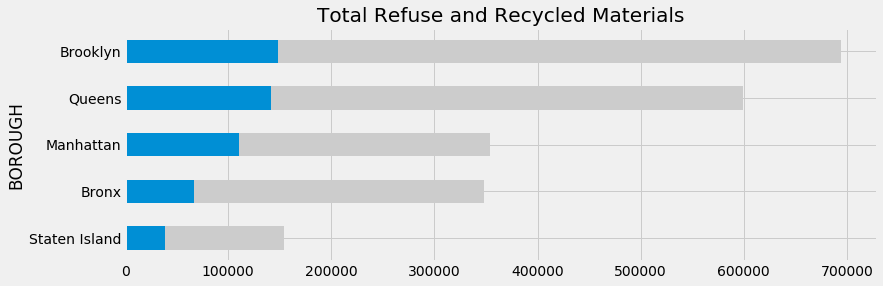

In [30]:
ax = df[df.year == 2019].groupby('BOROUGH').REFUSETONSCOLLECTED.sum().sort_values().plot(kind='barh', title='Total Recycled Materials', figsize=(12,4), color='#cccccc')
df[df.year == 2019].groupby('BOROUGH').total_recycled.sum().sort_values().plot(kind='barh', title='Total Refuse and Recycled Materials', figsize=(12,4), ax=ax)

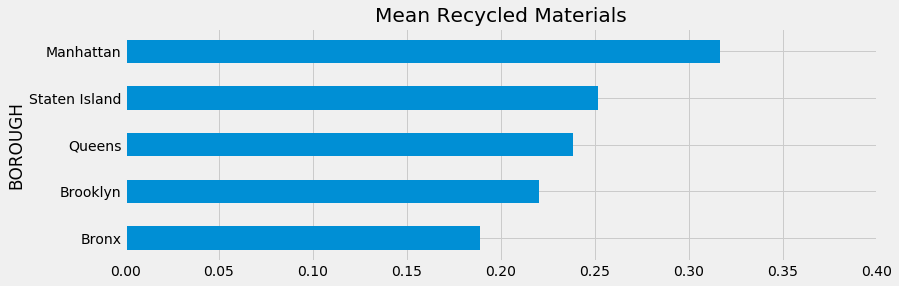

In [31]:
df[df.year == 2019].groupby('BOROUGH').percent_recycled.mean().sort_values().plot(kind='barh', title='Mean Recycled Materials', figsize=(12,4), xlim=(0,.4))

## Greatest shifts by district over time

In [32]:
bydist_2018 = df[df['year']==2018].groupby('borough_code').percent_recycled.mean().reset_index()
bydist_2009 = df[df['year']==2009].groupby('borough_code').percent_recycled.mean().reset_index()

bydist = pd.merge(bydist_2018,bydist_2009['percent_recycled'],left_index=True,right_index=True)
bydist.columns = ['borough_code','pct_recyc_2018','pct_recyc_2009']
bydist['pct_change'] = bydist['pct_recyc_2018'] / bydist['pct_recyc_2009'] - 1
bydist.to_csv('10-year-change.csv', index=False)
bydist.head()

,borough_code,pct_recyc_2018,pct_recyc_2009,pct_change
0,101,0.457068,0.525482,-0.130192
1,102,0.405030,0.357676,0.132396
2,103,0.220118,0.209310,0.051639
3,104,0.372049,0.376665,-0.012255
4,105,0.346514,0.334442,0.036097


In [33]:
print('The community districts that has the highest mean percent recycled')
print(df.groupby(['BOROUGH', 'COMMUNITYDISTRICT']).percent_recycled.mean().reset_index().sort_values('percent_recycled', ascending=False).head())
print('\n')
print('The community districts that has the lowest mean percent recycled')
print(df.groupby(['BOROUGH', 'COMMUNITYDISTRICT']).percent_recycled.mean().reset_index().sort_values('percent_recycled', ascending=True).head())

The community districts that has the highest mean percent recycled
      BOROUGH  COMMUNITYDISTRICT  percent_recycled
30  Manhattan                  1          0.456923
17   Brooklyn                  6          0.440357
31  Manhattan                  2          0.365111
33  Manhattan                  4          0.359387
36  Manhattan                  7          0.358198


The community districts that has the lowest mean percent recycled
     BOROUGH  COMMUNITYDISTRICT  percent_recycled
3      Bronx                  4          0.105543
0      Bronx                  1          0.105900
27  Brooklyn                 16          0.112781
8      Bronx                  9          0.116825
2      Bronx                  3          0.118954


In [34]:
demo_df = pd.read_csv('Bronx-2-indicators.csv')
demo_df.borocd = demo_df.borocd.astype(str)

# merging the bydist with some demographic data
merged = bydist.merge(demo_df, left_on='borough_code', right_on='borocd')

In [35]:
merged.to_csv('demographics_and_bydist.csv', index=False)

## 311 data regarding missed recyling collections

Data is <code>311_Service_Requests_from_2010_to_Present.csv</code>

I grabbed and filtered the data on NYC Open Data and filtered it to only include DSNY complaints mentioning recycling

In [14]:
df_311 = pd.read_csv('311_Service_Requests_from_2010_to_Present.csv', usecols=['Unique Key', 'Created Date', 'Agency', 'Agency Name', 'Complaint Type', 'Descriptor','Location Type', 'Incident Zip', 'Incident Address', 'Street Name', 'City', 'Resolution Description', 'Community Board', 'X Coordinate (State Plane)', 'Y Coordinate (State Plane)', 'Latitude', 'Longitude', 'Borough'])
df_311['year'] = df_311['Created Date'].str.extract('\d+\/\d+\/(\d+)') ## this grabs the year

FileNotFoundError: [Errno 2] File b'311_Service_Requests_from_2010_to_Present.csv' does not exist: b'311_Service_Requests_from_2010_to_Present.csv'

In [ ]:
df_311.head(1)

In [ ]:
df_311.year.value_counts().reset_index().sort_values('index', ascending=True).plot(kind='bar', x='index', y='year', legend=False)

In [ ]:
df_311['Community Board'].value_counts().head(10)

In [ ]:
df_311['Borough'].value_counts().head(6)